# Some basic molecular dynamic analysis with pytraj

## md trajectory analysis on rubisco systems with pytraj

In [1]:
%pylab inline
import pytraj as pt
import os
import seaborn as sns
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
from numpy import std, mean, sqrt, var
from scipy.stats import ttest_ind
from scipy import stats 


### functions defines (mainly because of the rubisco is a multimeric molecule)

In [3]:
#make the mask without the N,C terminal residues, in case their flexibity affect our analysis
str_mask=':'
s_e=[18,468]

for i in range(8):
    str_mask=str_mask+str(s_e[0]+477*i)+'-'+str(s_e[1]+477*i)+','
str_mask=str_mask+'3817-4840@C,N,O'
str_mask

':18-468,495-945,972-1422,1449-1899,1926-2376,2403-2853,2880-3330,3357-3807,3817-4840@C,N,O'

In [4]:
# basic distance analysis between Lys334 with Glu60(Glu547 same here)
# Lys 334 is at the apex of the loop6, which controls the closed or open state of the active site
# However, the concept of open/closed is meaningless. MD simulation enable us to quatify it.

def dis_cal(traj):
    d1=pt.distance(traj,':334@NZ :537@CD')    #distance between side chain NZ, CD (tail) atoms
    d2=pt.distance(traj,':334 :537')      #distance between the mass centers of the two residues
    return d1,d2

In [5]:
# calculate the distance above in the eight sites 
def dis_cal_8sites(traj):
    d1=array([])
    d2=array([])
    for i in range(4):
        r1=334+954*i
        r2=537+954*i
        r3=334+477+954*i
        r4=537-477+954*i
        dis_mask1=':'+str(r1)+'@NZ :'+str(r2)+'@CD'
        dis_mask2=':'+str(r1)+' :'+str(r2)
        dis_mask3=':'+str(r3)+'@NZ :'+str(r4)+'@CD'
        dis_mask4=':'+str(r3)+' :'+str(r4)
        d1=concatenate((d1,pt.distance(traj,dis_mask1)))
        d1=concatenate((d1,pt.distance(traj,dis_mask3))) 
        d2=concatenate((d2,pt.distance(traj,dis_mask2)))    
        d2=concatenate((d2,pt.distance(traj,dis_mask4)))    
    
    return d1,d2

In [6]:
# the main function to execute the MD analysis
# by now rmsd, radius gyration, distance,...

def md_analysis(runs):
    #runs='unact_rep01'
    traj_dir='/Volumes/zhili_8TB/new_model/'
    traj_path='/'.join([traj_dir,runs])
    os.chdir(traj_path+'/MMGBSA/')                       #cd the trajectory path

    traj = pt.iterload('*strip.nc', '*strip.parm7') #load the striped trajectory into 1000 frames
    traj=traj[::int(len(traj)/100)]      #set to read 1000 frames
    #superpose the trajectory to the first frame
    pt.superpose(traj, ref=0)
    rmsd_data_0 = pt.rmsd(traj, ref=0, mask='@C,N,O')
    rmsd_data_1 = pt.rmsd(traj, ref=0, mask=str_mask)
    rg_data = pt.radgyr(traj, '@CA')
    #d1,d2=dis_cal(traj)
    d1,d2=dis_cal_8sites(traj)
    #print(mean(rmsd_data_0),mean(rmsd_data_1),mean(rg_data))
    
    return rg_data,rmsd_data_0,rmsd_data_1,d1,d2
    

## distance vs open/closed

#### as said above the open/closed of the active site, is a thing needed to be pre-define. <br> lets try to find out the cutoff distance to cluster the [open]/[closed]<br> now we have two criterias: NZ-CD distance and the mass center distance. <br> lets check which one is more suitable to generate a cut off value.

In [7]:
#unact:no activation sites.  #mg:all activated sites.but no ligand bound
d1_dis=array([])
for runs in ['unact_rep01','unact_rep02','unact_rep03','unact_rep04','unact_rep05',
            'mg_rep01','mg_rep02','mg_rep03',]:
    rg_data,rmsd_data_0,rmsd_data_1,d1,d2=md_analysis(runs)

([<matplotlib.axis.XTick at 0x7f9b5cc01150>,
 <a list of 16 Text xticklabel objects>)

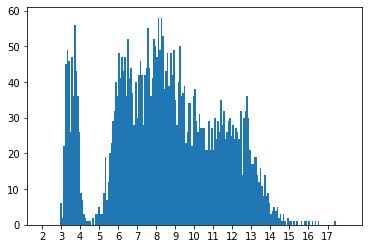

In [8]:
#see the data distribution to find the cutoff of open/closed state.
d1_dis=array([])
for runs in ['unact_rep01','unact_rep02','unact_rep03','unact_rep04','unact_rep05',]:   #no activation sites.
    rg_data,rmsd_data_0,rmsd_data_1,d1,d2=md_analysis(runs)
    d1_dis=concatenate((d1_dis,d1))
hist(d1_dis,bins=200,range=(2,18))
xticks(range(2,18,1))

([<matplotlib.axis.XTick at 0x7f9b8f9aba90>,
 <a list of 16 Text xticklabel objects>)

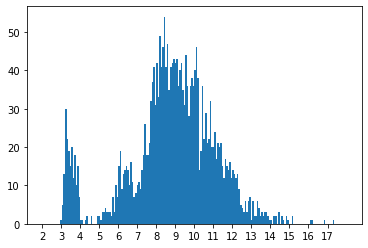

In [9]:
#see the data distribution to find the cutoff of open/closed state.
d1_dis=array([])
for runs in ['mg_rep01','mg_rep02','mg_rep03',]:   #all activated sites.
    rg_data,rmsd_data_0,rmsd_data_1,d1,d2=md_analysis(runs)
    d1_dis=concatenate((d1_dis,d1))
    #print(d1.shape)
hist(d1_dis,bins=200,range=(2,18))
xticks(range(2,18,1))

([<matplotlib.axis.XTick at 0x7f9b5bf4cad0>,
 <a list of 16 Text xticklabel objects>)

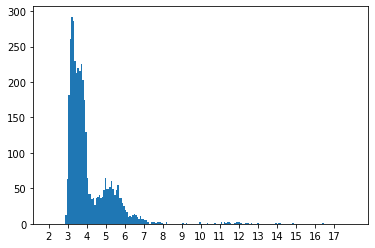

In [10]:
# eight activated sites were occupied by the rubp ligand
d1_dis=array([])
for runs in ['8rubp_1_rep01','8rubp_1_rep02','8rubp_1_rep03','8rubp_1_rep04','8rubp_1_rep05',]:   #no activation sites.
    rg_data,rmsd_data_0,rmsd_data_1,d1,d2=md_analysis(runs)
    d1_dis=concatenate((d1_dis,d1))
    #print(d1.shape)
hist(d1_dis,bins=200,range=(2,18))
xticks(range(2,18,1))

### clearly from three plots above, we find that the 4.5 or 4.6 A is good cutoff value.<br> As the salt bridge between Lys and Glu breaks after get further apart.

### now check the mass center distance

([<matplotlib.axis.XTick at 0x7f9b5c386a10>,
 <a list of 16 Text xticklabel objects>)

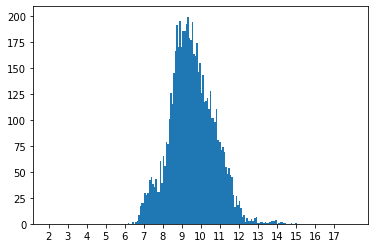

In [11]:
#see the data distribution to find the cutoff of open/closed state.
d2_dis=array([])
for runs in ['unact_rep01','unact_rep02','unact_rep03','unact_rep04','unact_rep05',
            'mg_rep01','mg_rep02','mg_rep03',]:
    rg_data,rmsd_data_0,rmsd_data_1,d1,d2=md_analysis(runs)
    d2_dis=concatenate((d2_dis,d2))

hist(d2_dis,bins=200,range=(2,18))
xticks(range(2,18,1))

([<matplotlib.axis.XTick at 0x7f9b5c34ab90>,
 <a list of 16 Text xticklabel objects>)

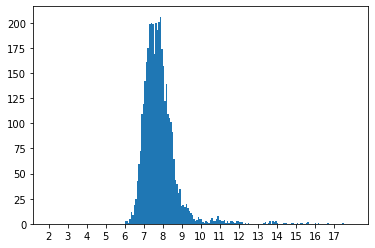

In [12]:
#see the data distribution to find the cutoff of open/closed state.
d2_dis=array([])
for runs in ['8rubp_1_rep01','8rubp_1_rep02','8rubp_1_rep03','8rubp_1_rep04','8rubp_1_rep05',]:   #no activation sites.
    rg_data,rmsd_data_0,rmsd_data_1,d1,d2=md_analysis(runs)
    d2_dis=concatenate((d2_dis,d2))

hist(d2_dis,bins=200,range=(2,18))
xticks(range(2,18,1))

### Obviously the answer is no. <br> the mass center distance is not a good metric to distinguish the open/closed state

## cluster with the open/closed state with the distance metric we got

In [13]:
#we know the machine learning clustering methods like Kmean 
#is very useful and commonly used in the MD frames partition.
#However, to solve a specific problem, a more speciallized metric is more useful

In [14]:
# the main function to execute the MD analysis
# by now rmsd, radius gyration, distance,...
# update: remove d2...

def md_analysis(runs):
    #runs='unact_rep01'
    traj_dir='/Volumes/zhili_8TB/new_model/'
    traj_path='/'.join([traj_dir,runs])
    os.chdir(traj_path+'/MMGBSA/')                       #cd the trajectory path

    traj = pt.iterload('*strip.nc', '*strip.parm7') #load the striped trajectory into 1000 frames
    traj=traj[::int(len(traj)/100)]      #set to read 1000 frames
    #superpose the trajectory to the first frame
    pt.superpose(traj, ref=0)
    rmsd_data_0 = pt.rmsd(traj, ref=0, mask='@C,N,O')
    rmsd_data_1 = pt.rmsd(traj, ref=0, mask=str_mask)
    rg_data = pt.radgyr(traj, '@CA')
    #d1,d2=dis_cal(traj)
    d1=dis_cal_8sites(traj)
    #print(mean(rmsd_data_0),mean(rmsd_data_1),mean(rg_data))
    
    return rg_data,rmsd_data_0,rmsd_data_1,d1
    

In [15]:
# calculate the distance above in the eight sites 
def dis_cal_8sites(traj):
    d1=array([])

    for i in range(4):
        r1=334+954*i
        r2=537+954*i
        r3=334+477+954*i
        r4=537-477+954*i
        dis_mask1=':'+str(r1)+'@NZ :'+str(r2)+'@CD'
        dis_mask3=':'+str(r3)+'@NZ :'+str(r4)+'@CD'
        d1=concatenate((d1,pt.distance(traj,dis_mask1)))
        d1=concatenate((d1,pt.distance(traj,dis_mask3)))  
    
    return d1

In [16]:
#cluster ratio by repeats
clu_ra=[]
for runs in ['unact_rep01','unact_rep02','unact_rep03','unact_rep04','unact_rep05',
            'mg_rep01','mg_rep02','mg_rep03',]:
    rg_data,rmsd_data_0,rmsd_data_1,d1=md_analysis(runs)
    clu_ra.append(len(d1[d1>4.5])/len(d1))
    print(runs,':',clu_ra[-1])

unact_rep01 : 0.88125
unact_rep02 : 0.8975
unact_rep03 : 0.83375
unact_rep04 : 0.87
unact_rep05 : 0.93875
mg_rep01 : 0.93625
mg_rep02 : 0.95625
mg_rep03 : 0.8675


In [17]:
#cluster ratio by repeats
clu_ra=[]
for runs in ['8rubp_1_rep01','8rubp_1_rep02','8rubp_1_rep03','8rubp_1_rep04','8rubp_1_rep05',]:
    rg_data,rmsd_data_0,rmsd_data_1,d1=md_analysis(runs)
    clu_ra.append(len(d1[d1>4.5])/len(d1))
    print(runs,':',clu_ra[-1])

8rubp_1_rep01 : 0.1925
8rubp_1_rep02 : 0.24
8rubp_1_rep03 : 0.33375
8rubp_1_rep04 : 0.27
8rubp_1_rep05 : 0.26125


### clearly the open ratio: activated apo > activated > activated with 8rubp

## before we conclude our final results into a table, lets check the correlations between the protein property and the active site properties.

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


unact_rep01 0.9578983889721523


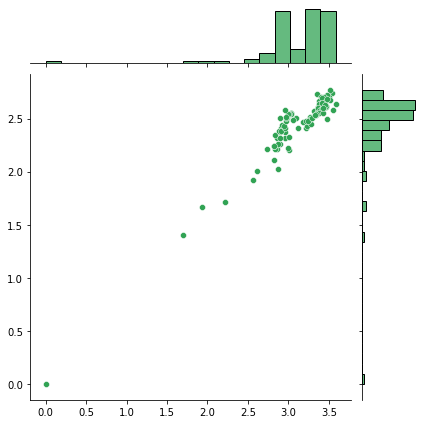

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


unact_rep02 0.9682278937753461


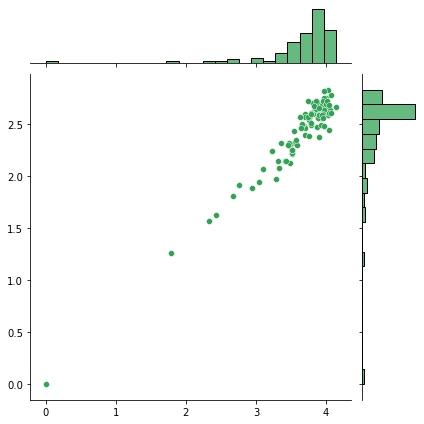

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


unact_rep03 0.976667667586591


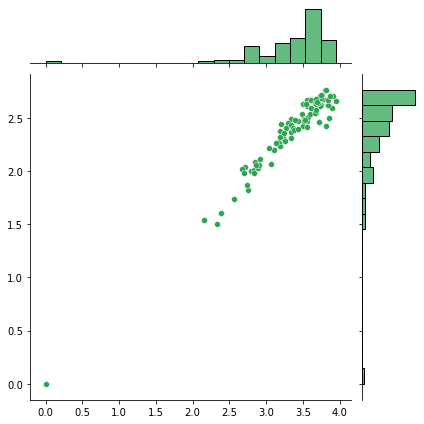

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


unact_rep04 0.9869096059664031


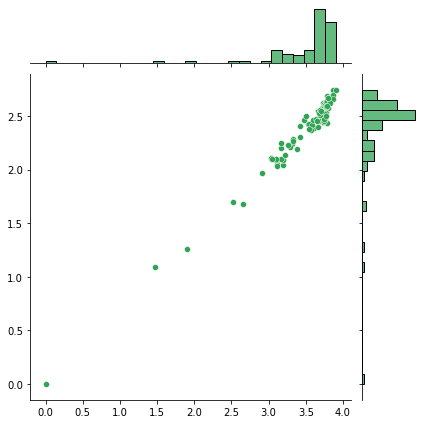

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


unact_rep05 0.9535272280520456


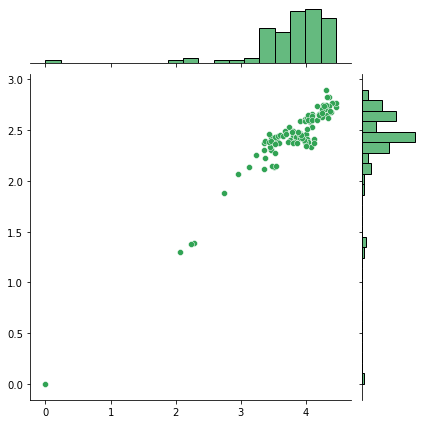

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


mg_rep01 0.9779970316032911


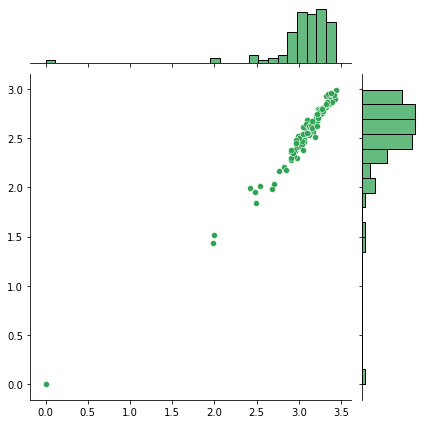

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


mg_rep02 0.9715583570742091


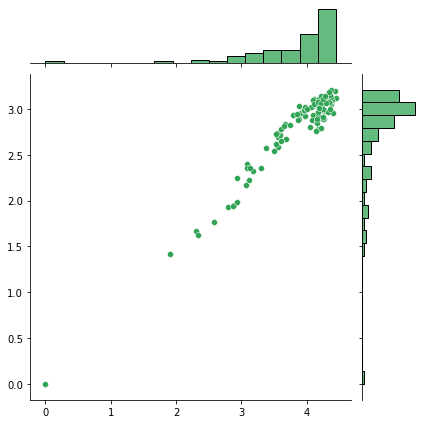

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


mg_rep03 0.9353449115147691


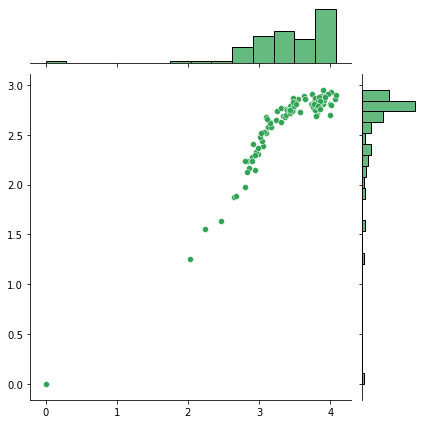

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep01 0.8774654505815714


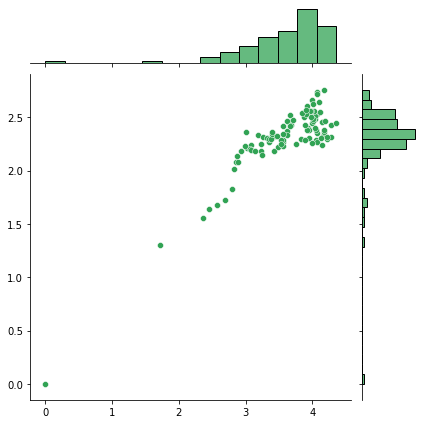

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep02 0.891063423209959


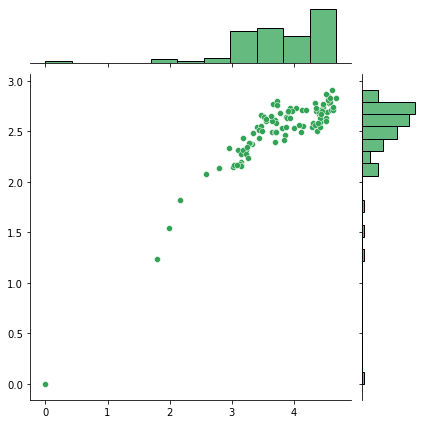

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep03 0.9629700075213133


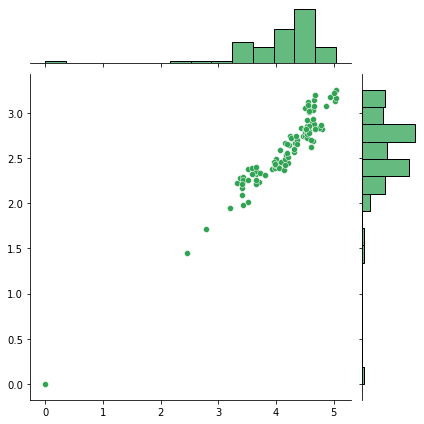

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep04 0.870144500069528


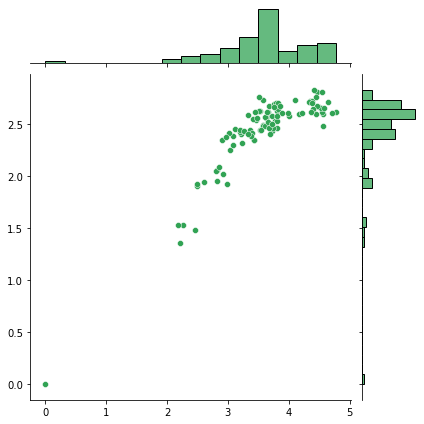

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep05 0.9295878736899775


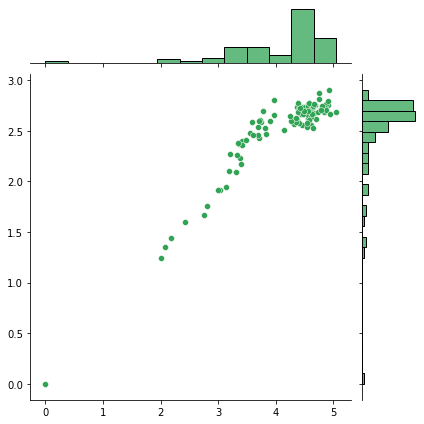

In [18]:
#rmsd_0 vs rmsd_1 include tail or not
clu_ra=[]
for runs in ['unact_rep01','unact_rep02','unact_rep03','unact_rep04','unact_rep05',
            'mg_rep01','mg_rep02','mg_rep03',
            '8rubp_1_rep01','8rubp_1_rep02','8rubp_1_rep03','8rubp_1_rep04','8rubp_1_rep05',]:
    rg_data,rmsd_data_0,rmsd_data_1,d1=md_analysis(runs)
    sns.jointplot(rmsd_data_0, rmsd_data_1, color="#31a354")
    r,p=stats.pearsonr(rmsd_data_0, rmsd_data_1)
    print(runs,r)
    show()

### the correlation shows that, when the activated sites are occcupied by the rubp ligands, the N,C-terminus have some functions with rubisco protein (rmsd) states...

In [19]:
# so, apo rubisco is safe to use either one rmsd metric. 
#8rubp may need to check both rmsd metric for further investigation

### gyration vs rmsd

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


unact_rep01 0.905126331766113


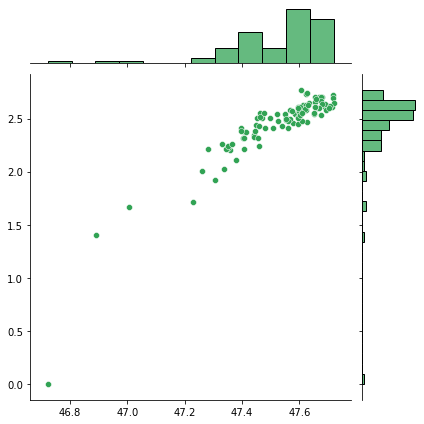

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


unact_rep02 0.9109014893824064


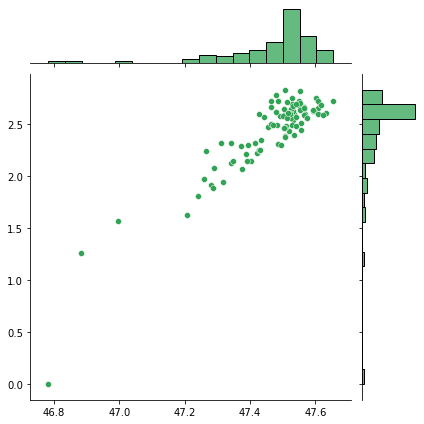

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


unact_rep03 0.9253264674333214


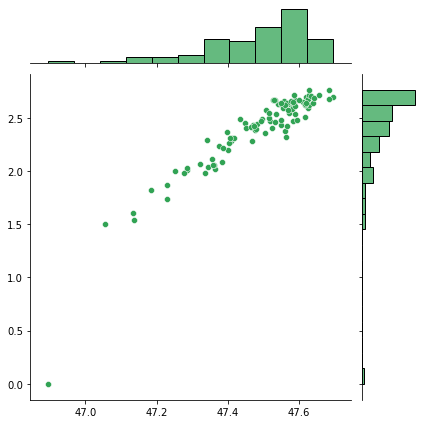

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


unact_rep04 0.9393539531436496


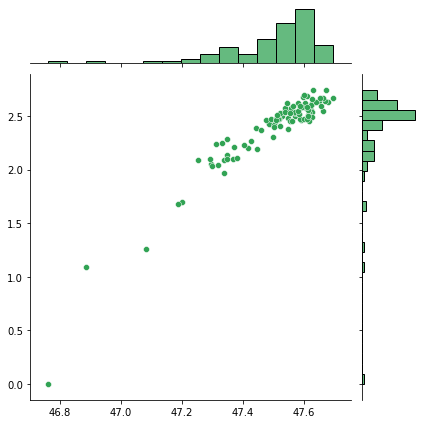

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


unact_rep05 0.8484455812814562


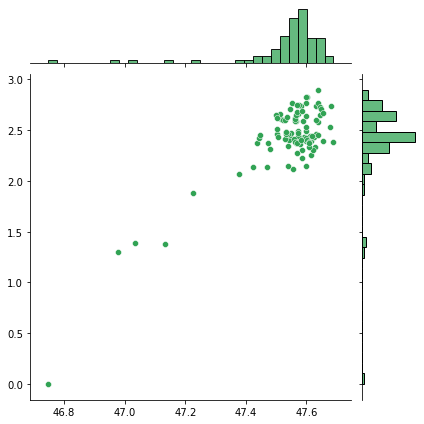

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


mg_rep01 0.8924832810507006


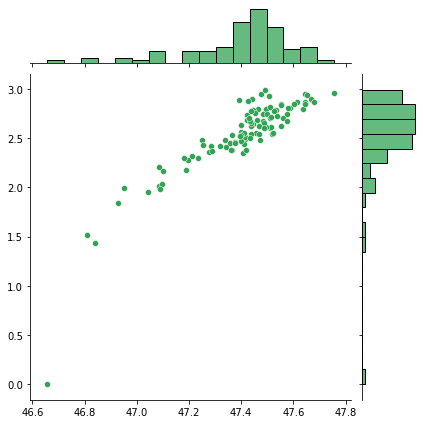

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


mg_rep02 0.9445715229696041


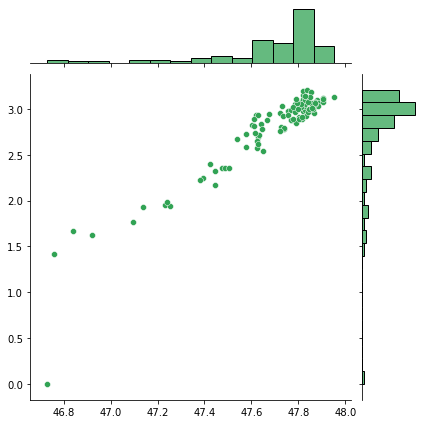

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


mg_rep03 0.9470077603698194


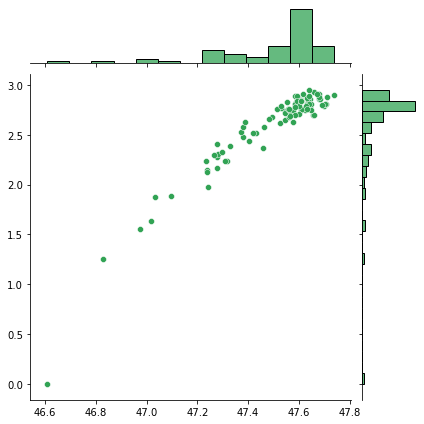

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep01 0.8052003808471673


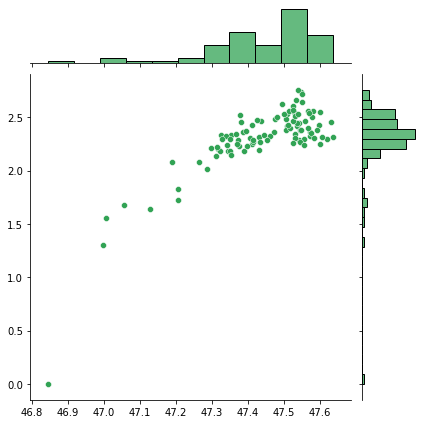

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep02 0.8391277860587202


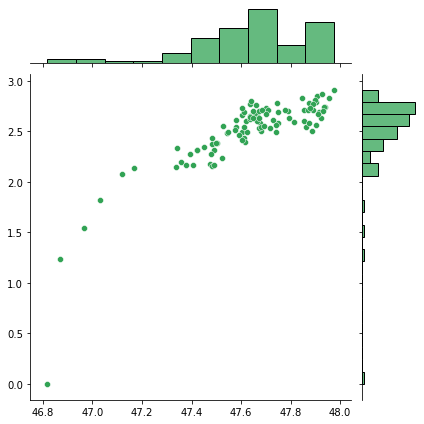

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep03 0.9364413400525314


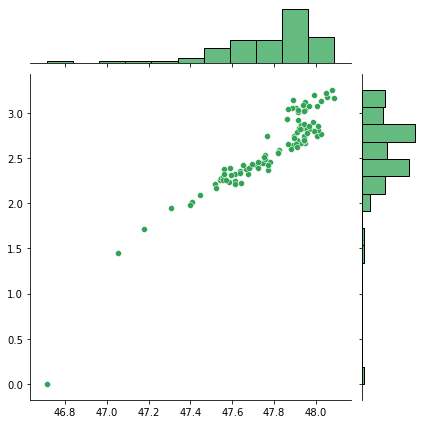

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep04 0.9307522320383527


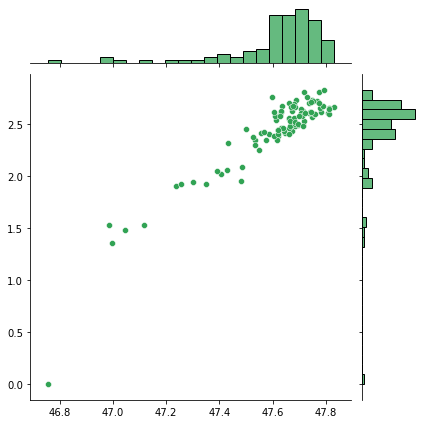

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep05 0.8776611788322475


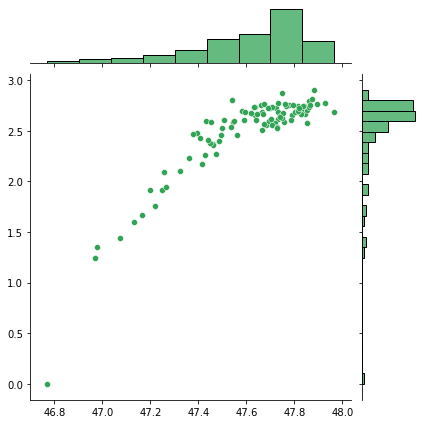

In [20]:
#radius of gyration vs rmsd 
clu_ra=[]
for runs in ['unact_rep01','unact_rep02','unact_rep03','unact_rep04','unact_rep05',
            'mg_rep01','mg_rep02','mg_rep03',
            '8rubp_1_rep01','8rubp_1_rep02','8rubp_1_rep03','8rubp_1_rep04','8rubp_1_rep05',]:
    rg_data,rmsd_data_0,rmsd_data_1,d1=md_analysis(runs)
    sns.jointplot(rg_data, rmsd_data_1, color="#31a354")
    r,p=stats.pearsonr(rg_data, rmsd_data_1)
    print(runs,r)
    show()

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep01 0.9222900467299884


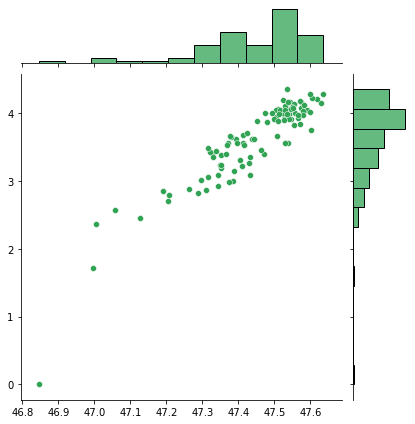

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep02 0.9475792050528438


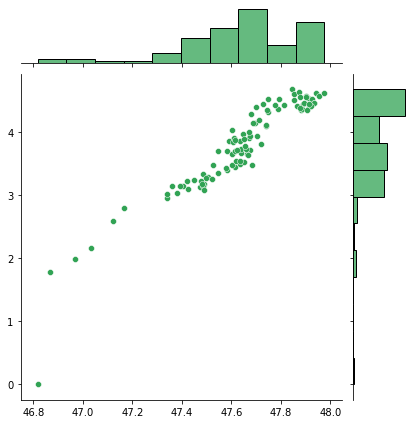

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep03 0.9476770867092245


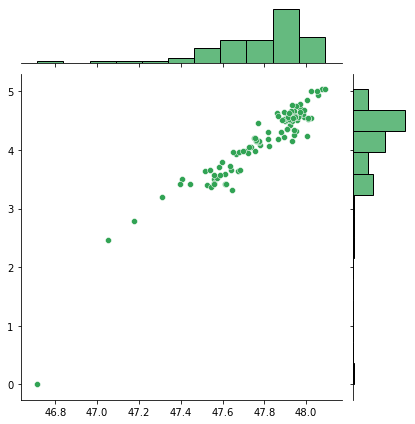

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep04 0.8972224463626014


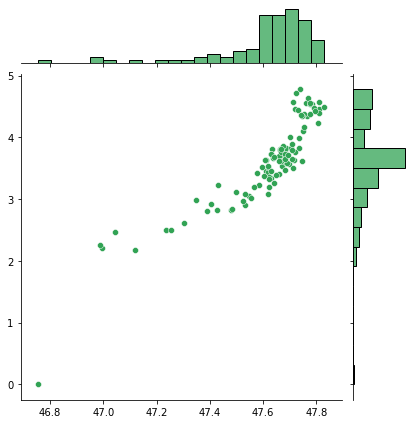

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep05 0.9496046822736515


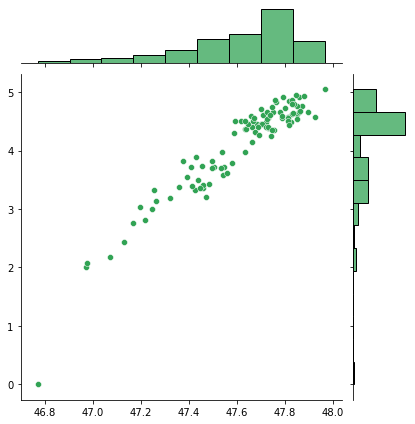

In [21]:
#radius of gyration vs rmsd 
clu_ra=[]
for runs in ['8rubp_1_rep01','8rubp_1_rep02','8rubp_1_rep03','8rubp_1_rep04','8rubp_1_rep05',]:
    rg_data,rmsd_data_0,rmsd_data_1,d1=md_analysis(runs)
    sns.jointplot(rg_data, rmsd_data_0, color="#31a354")
    r,p=stats.pearsonr(rg_data, rmsd_data_0)
    print(runs,r)
    show()

### highly correlated

## distance vs rmsd

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


unact_rep01 0.28642961100076914


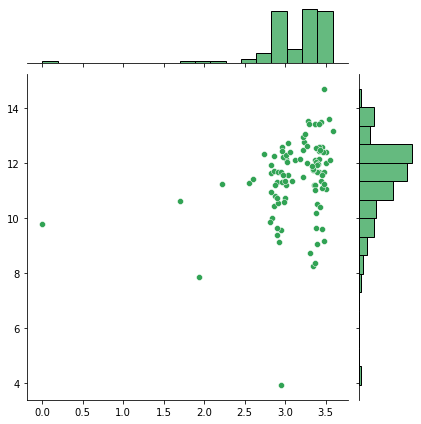

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


unact_rep02 -0.180852071996802


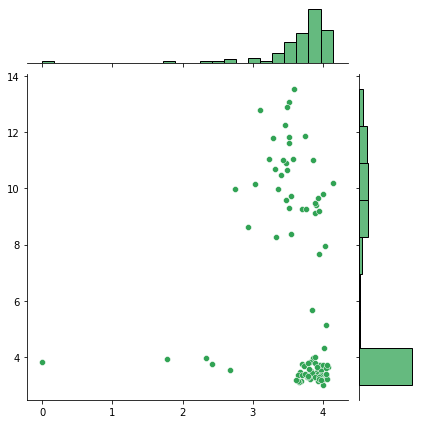

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


unact_rep03 -0.35659968147806836


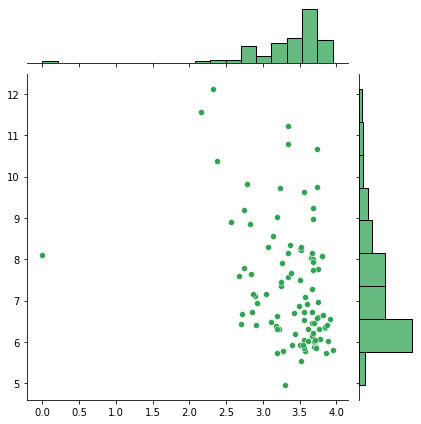

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


unact_rep04 -0.6201965850838413


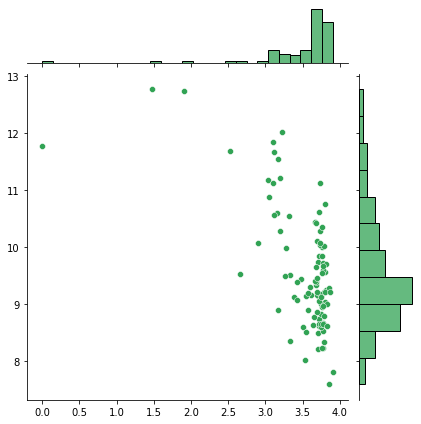

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


unact_rep05 -0.0507241107959975


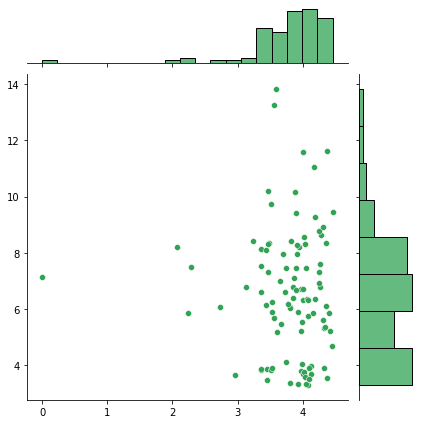

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


mg_rep01 -0.1813146690416412


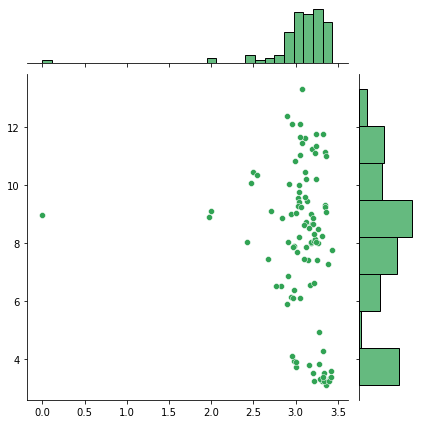

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


mg_rep02 -0.6070482229541836


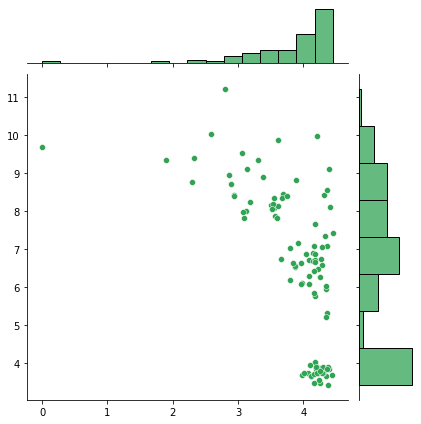

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


mg_rep03 -0.2530856267971502


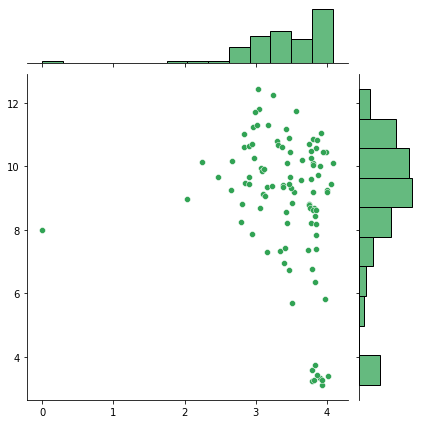

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep01 -0.0506362014138948


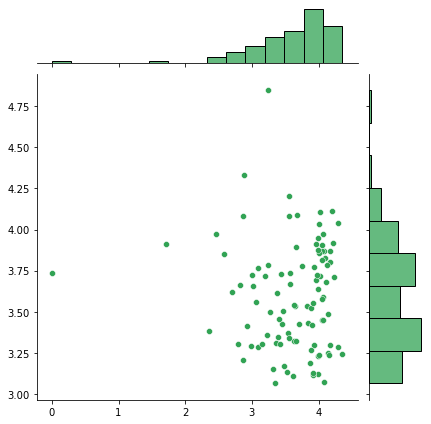

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep02 -0.6389251875590819


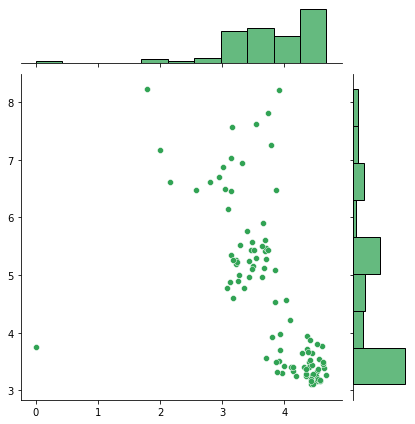

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep03 0.720333736533421


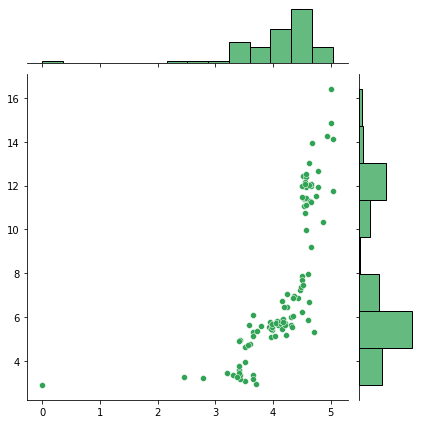

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep04 0.7220107660974836


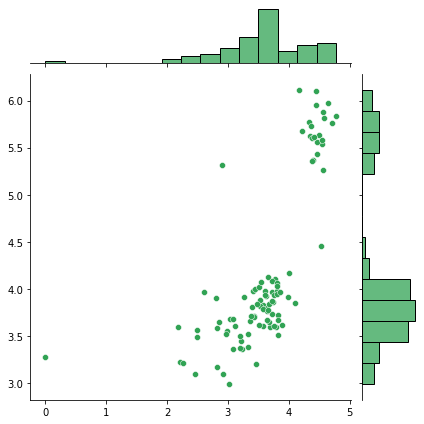

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep05 0.12256098377816926


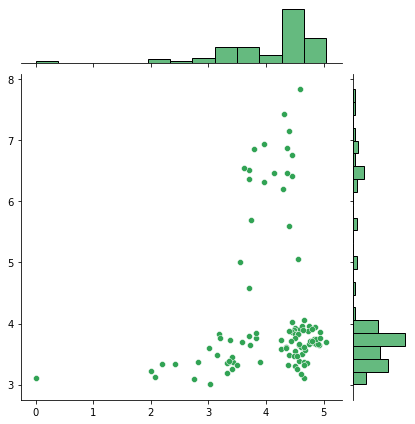

In [22]:
#cluster ratio by repeats
clu_ra=[]
for runs in ['unact_rep01','unact_rep02','unact_rep03','unact_rep04','unact_rep05',
            'mg_rep01','mg_rep02','mg_rep03',
            '8rubp_1_rep01','8rubp_1_rep02','8rubp_1_rep03','8rubp_1_rep04','8rubp_1_rep05',]:
    rg_data,rmsd_data_0,rmsd_data_1,d1=md_analysis(runs)
    sns.jointplot(rmsd_data_0, d1[:int(len(d1)/8)], color="#31a354") #lets quickly check the rmsd with first active distance metric
    r,p=stats.pearsonr(rmsd_data_0, d1[:int(len(d1)/8)])
    print(runs,r)
    show()

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep01 -0.17178654282010333


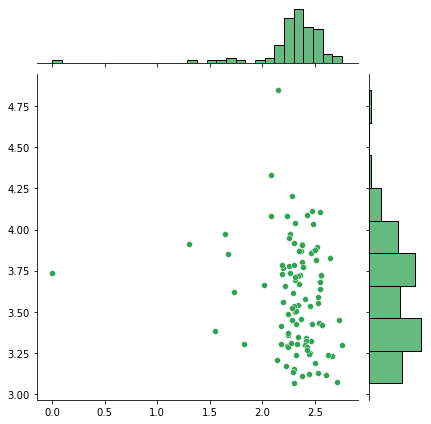

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep02 -0.3861771048761076


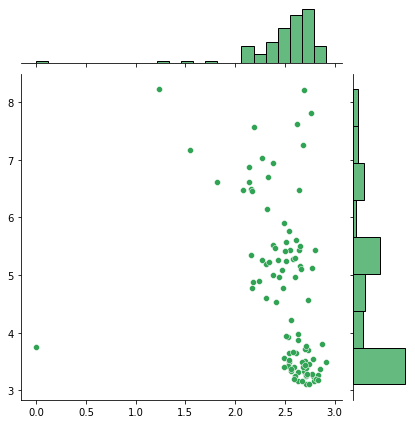

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep03 0.7715380309109867


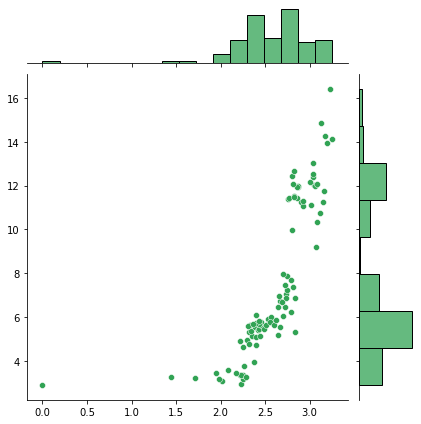

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep04 0.42695824527465687


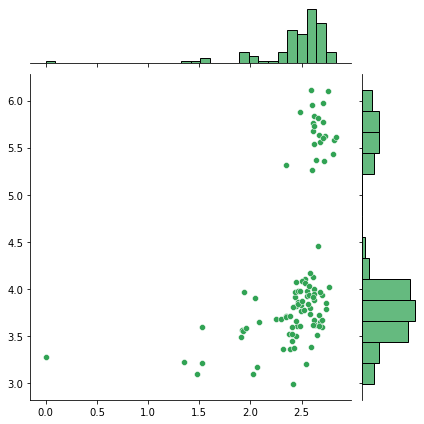

/Users/czl/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


8rubp_1_rep05 0.2554218156262128


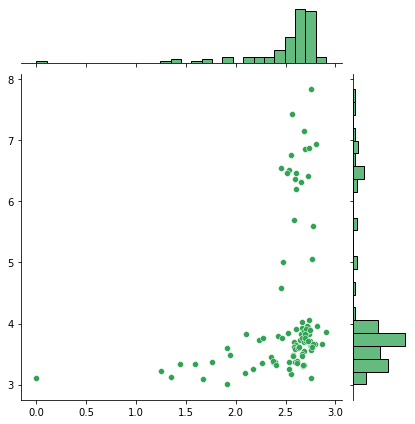

In [23]:
#cluster ratio by repeats
clu_ra=[]
for runs in ['8rubp_1_rep01','8rubp_1_rep02','8rubp_1_rep03','8rubp_1_rep04','8rubp_1_rep05',]:
    rg_data,rmsd_data_0,rmsd_data_1,d1=md_analysis(runs)
    sns.jointplot(rmsd_data_1, d1[:int(len(d1)/8)], color="#31a354")
    r,p=stats.pearsonr(rmsd_data_1, d1[:int(len(d1)/8)])
    print(runs,r)
    show()

In [24]:
## no need to waste too much time on this ... I guess
#maybe try to find the correlation between distance metrics of 8 sites.

In [25]:
#cluster ratio by repeats
clu_ra=[]
for runs in ['unact_rep01','unact_rep02','unact_rep03','unact_rep04','unact_rep05',
            'mg_rep01','mg_rep02','mg_rep03',
            '8rubp_1_rep01','8rubp_1_rep02','8rubp_1_rep03','8rubp_1_rep04','8rubp_1_rep05',]:
    rg_data,rmsd_data_0,rmsd_data_1,d1=md_analysis(runs)
    
    maxr=0
    for i in range(8):
        for j in range(8):
            if i!=j:     
                r,p=stats.pearsonr(d1[i*100:i*100+100], d1[j*100:j*100+100])
                if abs(r)> abs(maxr):
                    maxr=r
                    maxp=p
                    maxi=i
                    maxj=j
    print(runs,maxi+1,maxj+1,maxr,maxp)


unact_rep01 5 8 0.5787070147562267 2.8570741134171247e-10
unact_rep02 4 5 0.49737387708104247 1.40726828259629e-07
unact_rep03 2 4 0.4973546916613681 1.4090683785961443e-07
unact_rep04 2 5 0.38753904484601875 6.790654554675942e-05
unact_rep05 4 5 0.7270787036133866 1.0813704843521946e-17
mg_rep01 6 7 0.5574897175061112 1.6939647546115624e-09
mg_rep02 1 3 -0.6037644694086488 2.942289035719844e-11
mg_rep03 2 7 -0.5208190082482758 2.778597388160898e-08
8rubp_1_rep01 7 8 0.28853530137312267 0.0035997114967749313
8rubp_1_rep02 4 5 0.37871228393886575 0.00010221883070070725
8rubp_1_rep03 1 5 0.7458758970579561 5.43320754680573e-19
8rubp_1_rep04 1 6 0.4718925172337075 7.188799847467512e-07
8rubp_1_rep05 5 7 0.5298979110365181 1.4335190296746934e-08


In [26]:
#anyway ignore these... no correlations even the highest correlation is not significent enough
#and there is no hypothesis to test from this.

## make the table of results

In [27]:
# the main function to execute the MD analysis
# by now rmsd, radius gyration, distance,...
# update: remove d2...

def md_analysis(runs):
    #runs='unact_rep01'
    traj_dir='/Volumes/zhili_8TB/new_model/'
    traj_path='/'.join([traj_dir,runs])
    os.chdir(traj_path+'/MMGBSA/')                       #cd the trajectory path

    traj = pt.iterload('*strip.nc', '*strip.parm7') #load the striped trajectory into 1000 frames

    traj=traj[int(len(traj)*0.75)::int(len(traj)*0.25/250)]     # set to read 250 frames of last 250 ns 
    #traj=traj[::int(len(traj)/1000)]     #set to read 1000 frames of 1000 ns 

    #superpose the trajectory to the first frame
    pt.superpose(traj, ref=0)
    rmsd_data_0 = pt.rmsd(traj, ref=0, mask='@C,N,O')
    rmsd_data_1 = pt.rmsd(traj, ref=0, mask=str_mask)
    rg_data = pt.radgyr(traj, '@CA')
    #d1,d2=dis_cal(traj)
    d1=dis_cal_8sites(traj)
    #print(mean(rmsd_data_0),mean(rmsd_data_1),mean(rg_data))
    
    return rg_data,rmsd_data_0,rmsd_data_1,d1
    

In [28]:
sub_name=['unact_rep01','unact_rep02','unact_rep03','unact_rep04','unact_rep05',
            'mg_rep01','mg_rep02','mg_rep03',
            '8rubp_1_rep01','8rubp_1_rep02','8rubp_1_rep03','8rubp_1_rep04','8rubp_1_rep05',]
df = pd.DataFrame(index=sub_name,columns=['radius gyration','rmsd_data_full','rmsd_data_no_ter',
                                          'd1','open state ratio*100%'])

In [29]:
df1 = df.copy()
#cluster ratio by repeats
for runs in sub_name:
    data=[]
    rg_data,rmsd_data_0,rmsd_data_1,d1=md_analysis(runs)
    data.append(mean(rg_data))
    data.append(mean(rmsd_data_0))
    data.append(mean(rmsd_data_1))
    data.append(mean(d1))
    data.append(100*len(d1[d1>4.5])/len(d1))
    
    df1.loc[runs]=data
df1

,radius gyration,rmsd_data_full,rmsd_data_no_ter,d1,open state ratio*100%
unact_rep01,47.651614,1.71486,1.415301,8.380213,84.8
unact_rep02,47.556767,2.155228,1.402001,7.983228,83.75
unact_rep03,47.607484,1.623948,1.360114,7.586259,80.65
unact_rep04,47.616046,1.503107,1.305767,7.458653,86.9
unact_rep05,47.595121,1.844484,1.4656,8.453339,92.95
mg_rep01,47.580976,1.710103,1.564575,7.720938,81.0
mg_rep02,47.83612,2.07115,1.298735,8.47861,87.05
mg_rep03,47.624421,1.641118,1.315593,7.323665,67.35
8rubp_1_rep01,47.538135,2.083101,1.655805,3.85931,17.0
8rubp_1_rep02,47.884479,2.453784,1.661131,3.731425,12.55


## The content open state active sites in 1rubps

In [30]:
# the main function to execute the MD analysis
# by now rmsd, radius gyration, distance,...
# update: remove d2...

def contect_analysis(runs):
    #runs='unact_rep01'
    traj_dir='/Volumes/zhili_8TB/new_model/'
    traj_path='/'.join([traj_dir,runs])
    os.chdir(traj_path+'/MMGBSA/')                       #cd the trajectory path
    traj = pt.iterload('*strip.nc', '*strip.parm7') #load the striped trajectory into 1000 frames
    traj=traj[int(len(traj)*0.75)::int(len(traj)*0.25/250)]     # set to read 250 frames of last 250 ns 

    #superpose the trajectory to the first frame
    pt.superpose(traj, ref=0)
    d1=dis_cal_8sites(traj)
    
    return d1
    

In [31]:
sub_name=['1rubp_rep01','1rubp_rep02','1rubp_rep03','1rubp_rep04','1rubp_rep05',]
df = pd.DataFrame(index=sub_name,columns=['s1','s2','s3','s4','s5','s6','s7','s8'])

In [32]:
df1 = df.copy()
#cluster ratio by repeats
for runs in sub_name:
    data=[]
    d1=contect_analysis(runs)
    for i in range(8):
        dd=d1[i*250:i*250+250]
        data.append(100*len(dd[dd>4.5])/len(dd))

    df1.loc[runs]=data
df1

,s1,s2,s3,s4,s5,s6,s7,s8
1rubp_rep01,5.6,99.6,100.0,42.8,100.0,96.8,100.0,52.4
1rubp_rep02,93.6,99.6,0.4,69.2,65.2,18.0,100.0,93.6
1rubp_rep03,5.6,99.2,95.2,100.0,61.6,97.2,100.0,95.6
1rubp_rep04,0.0,88.4,99.6,100.0,74.8,100.0,100.0,99.2
1rubp_rep05,0.8,100.0,99.2,100.0,100.0,100.0,99.2,100.0


## DSSP analysis on the N,C-terminus

cohen's d, the mean difference / pooled std
reference values: 0.01,0.2,0.5,0.8,1.2,2.0

high in value, relativly acceptable difference of two sample
small, small difference. need larger sample size

In [33]:
def cohen_d(x,y):   #do cohen's d to test effect size  cheak the difference between two distribution
    nx = len(x) 
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)


In [34]:
def f_test(x,y):   #ratio of two dataset variance 
    fstat = var(x,ddof=1)/var(y,ddof=1)
    nx = len(x)
    ny = len(y)
    p_value = stats.f.cdf(fstat,nx-1,ny-1)
    return fstat,p_value
    